In [1]:
import numpy as np
import json
import pandas as pd
import sys
import os
# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [15]:
# ===================================================================================================
# COMPREHENSIVE PREPROCESSING AND TRAINING PIPELINE
# ===================================================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class IncomePreprocessor:
    """Complete preprocessing pipeline for income prediction"""
    
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.feature_selector = None
        self.selected_features = None
        self.poly_transformer = None
        
    def create_advanced_features(self, df):
        """Create advanced feature engineering"""
        df_enhanced = df.copy()
        
        # 1. Age-based features
        df_enhanced['age_squared'] = df_enhanced['age'] ** 2
        df_enhanced['age_log'] = np.log1p(df_enhanced['age'])
        
        # Age groups
        df_enhanced['is_prime_earning'] = ((df_enhanced['age'] >= 35) & (df_enhanced['age'] <= 55)).astype(int)
        df_enhanced['is_early_career'] = ((df_enhanced['age'] >= 22) & (df_enhanced['age'] <= 35)).astype(int)
        df_enhanced['is_senior_worker'] = (df_enhanced['age'] > 55).astype(int)
        
        # 2. Education features
        df_enhanced['education_squared'] = df_enhanced['educational-num'] ** 2
        df_enhanced['is_graduate'] = (df_enhanced['educational-num'] >= 13).astype(int)
        df_enhanced['is_postgrad'] = (df_enhanced['educational-num'] >= 15).astype(int)
        
        # 3. Work hours features
        df_enhanced['hours_squared'] = df_enhanced['hours-per-week'] ** 2
        df_enhanced['is_part_time'] = (df_enhanced['hours-per-week'] < 35).astype(int)
        df_enhanced['is_overtime'] = (df_enhanced['hours-per-week'] > 45).astype(int)
        
        # 4. Work experience proxy
        df_enhanced['work_experience'] = np.maximum(df_enhanced['age'] - df_enhanced['educational-num'] - 6, 0)
        df_enhanced['experience_ratio'] = df_enhanced['work_experience'] / (df_enhanced['age'] + 1)
        
        # 5. Key interactions
        df_enhanced['age_education'] = df_enhanced['age'] * df_enhanced['educational-num']
        df_enhanced['age_hours'] = df_enhanced['age'] * df_enhanced['hours-per-week']
        df_enhanced['education_hours'] = df_enhanced['educational-num'] * df_enhanced['hours-per-week']
        
        # 6. Capital features
        df_enhanced['total_capital'] = df_enhanced['capital_gain_bin'] + df_enhanced['capital_loss_bin']
        df_enhanced['has_capital'] = (df_enhanced['total_capital'] > 0).astype(int)
        
        # 7. Professional indicators
        df_enhanced['likely_professional'] = ((df_enhanced['educational-num'] >= 15) & 
                                             (df_enhanced['hours-per-week'] >= 40)).astype(int)
        
        return df_enhanced
    
    def preprocess_data(self, df, is_training=True):
        """Complete preprocessing pipeline"""
        df_processed = df.copy()
        
        # Handle capital gains/losses
        if 'capital-gain' in df_processed.columns:
            # Create bins for capital gain/loss
            cap_gain_max = df_processed['capital-gain'].max()
            raw_bins = [-1, 0.0, 2000, 10000, cap_gain_max]
            clean_bins = sorted(set(raw_bins))
            labels = ['None', 'Low', 'Medium', 'High'][:len(clean_bins) - 1]
            
            df_processed['capital_gain_bin'] = pd.cut(
                df_processed['capital-gain'], bins=clean_bins, labels=labels, include_lowest=True
            )
            df_processed['capital_loss_bin'] = pd.cut(
                df_processed['capital-loss'], bins=clean_bins, labels=labels, include_lowest=True
            )
            
            # Convert to numeric
            df_processed['capital_gain_bin'] = df_processed['capital_gain_bin'].cat.codes
            df_processed['capital_loss_bin'] = df_processed['capital_loss_bin'].cat.codes
            
            # Drop original columns
            df_processed.drop(columns=['capital-gain', 'capital-loss'], inplace=True)
        
        # Convert income to binary
        if 'income' in df_processed.columns:
            df_processed['income'] = df_processed['income'].apply(lambda x: 1 if x == '>50K' else 0)
        
        # Transform fnlwgt
        df_processed['fnlwgt'] = np.log1p(df_processed['fnlwgt'])
        
        # Identify categorical columns
        numerical_cols = ['age', 'fnlwgt', 'educational-num', 'hours-per-week']
        if 'income' in df_processed.columns:
            numerical_cols.append('income')
        if 'capital_gain_bin' in df_processed.columns:
            numerical_cols.extend(['capital_gain_bin', 'capital_loss_bin'])
        
        categorical_cols = [col for col in df_processed.columns if col not in numerical_cols]
        
        # Encode categorical variables
        for col in categorical_cols:
            if is_training:
                self.label_encoders[col] = LabelEncoder()
                df_processed[col] = self.label_encoders[col].fit_transform(df_processed[col])
            else:
                if col in self.label_encoders:
                    # Handle unseen categories
                    le = self.label_encoders[col]
                    df_processed[col] = df_processed[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
                else:
                    df_processed[col] = 0  # Default value for missing encoder
        
        return df_processed
    
    def fit_transform(self, df):
        """Fit preprocessing pipeline and transform training data"""
        # Basic preprocessing
        df_processed = self.preprocess_data(df, is_training=True)
        
        # Create advanced features
        df_enhanced = self.create_advanced_features(df_processed)
        
        # Separate features and target
        X = df_enhanced.drop(columns=['income'])
        y = df_enhanced['income']
        
        # Remove constant features
        var_threshold = VarianceThreshold(threshold=0.01)
        X_var = var_threshold.fit_transform(X)
        X = pd.DataFrame(X_var, columns=X.columns[var_threshold.get_support()], index=X.index)
        
        
        self.selected_features = ['fnlwgt', 'relationship', 'occupation', 'marital-status', 'age_hours',
       'age_education', 'education_hours', 'workclass', 'experience_ratio',
       'total_capital', 'education_squared', 'educational-num', 'age_log',
       'age', 'age_squared', 'work_experience', 'is_graduate',
       'hours-per-week', 'hours_squared', 'capital_gain_bin', 'has_capital',
       'native-country', 'race', 'gender', 'education', 'capital_loss_bin',
       'is_overtime', 'is_prime_earning', 'is_part_time', 'is_early_career',
       'is_postgrad', 'likely_professional', 'is_senior_worker']
        
        X_selected = X[self.selected_features]
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X_selected)
        X_final = pd.DataFrame(X_scaled, columns=self.selected_features, index=X.index)
        
        print(f"✅ Training preprocessing complete:")
        print(f"   - Original features: {df.shape[1]}")
        print(f"   - Enhanced features: {len(X.columns)}")
        print(f"   - Selected features: {len(self.selected_features)}")
        print(f"   - Final dataset shape: {X_final.shape}")
        
        return X_final, y
    
    def transform(self, df):
        """Transform validation/test data using fitted pipeline"""
        # Basic preprocessing
        df_processed = self.preprocess_data(df, is_training=False)
        
        # Create advanced features
        df_enhanced = self.create_advanced_features(df_processed)
        
        # Separate features and target
        if 'income' in df_enhanced.columns:
            X = df_enhanced.drop(columns=['income'])
            y = df_enhanced['income']
        else:
            X = df_enhanced
            y = None
        
        # Select only the features used in training
        missing_features = set(self.selected_features) - set(X.columns)
        if missing_features:
            print(f"⚠️  Missing features in validation data: {missing_features}")
            # Add missing features with zeros
            for feature in missing_features:
                X[feature] = 0
        
        # Keep only selected features
        X_selected = X[self.selected_features]
        
        # Scale features
        X_scaled = self.scaler.transform(X_selected)
        X_final = pd.DataFrame(X_scaled, columns=self.selected_features, index=X.index)
        
        print(f"✅ Validation preprocessing complete:")
        print(f"   - Final dataset shape: {X_final.shape}")
        
        return X_final, y

# Initialize preprocessor
preprocessor = IncomePreprocessor()

print("🚀 Starting comprehensive preprocessing pipeline...")
print("=" * 80)

🚀 Starting comprehensive preprocessing pipeline...


In [16]:
# ===================================================================================================
# PROCESS TRAINING DATA
# ===================================================================================================

# Load and process training data
print("📊 Processing training data...")
print("-" * 50)

# Use the original dataframes loaded at the beginning
df_train = pd.read_parquet('train.parquet')
df_val = pd.read_parquet('validation.parquet')

print(f"Training data shape: {df_train.shape}")
print(f"Validation data shape: {df_val.shape}")

# Process training data
X_train_processed, y_train = preprocessor.fit_transform(df_train)

# Check class distribution
print(f"\n📈 Training class distribution:")
print(f"   Class 0 (≤50K): {(y_train == 0).sum():,}")
print(f"   Class 1 (>50K): {(y_train == 1).sum():,}")
print(f"   Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

print(f"\n✅ Training data ready for model training!")
print(f"   Features shape: {X_train_processed.shape}")
print(f"   Target shape: {y_train.shape}")
X_train_processed.head()

📊 Processing training data...
--------------------------------------------------
Training data shape: (38462, 15)
Validation data shape: (5495, 15)
✅ Training preprocessing complete:
   - Original features: 15
   - Enhanced features: 33
   - Selected features: 33
   - Final dataset shape: (38462, 33)

📈 Training class distribution:
   Class 0 (≤50K): 29,250
   Class 1 (>50K): 9,212
   Ratio: 3.18:1

✅ Training data ready for model training!
   Features shape: (38462, 33)
   Target shape: (38462,)


,fnlwgt,relationship,occupation,marital-status,age_hours,age_education,education_hours,workclass,experience_ratio,total_capital,...,gender,education,capital_loss_bin,is_overtime,is_prime_earning,is_part_time,is_early_career,is_postgrad,likely_professional,is_senior_worker
0,0.224039,0.975223,1.755274,0.917553,-1.139797,-0.985609,-0.794677,0.091454,-0.894942,-0.357102,...,0.703112,0.187089,-0.20966,-0.533835,-0.889389,2.187578,1.337127,-0.175245,-0.160508,-0.384328
1,1.118157,-0.898542,1.755274,-0.409148,1.976146,0.386941,0.717557,1.459336,1.008391,-0.357102,...,0.703112,0.187089,-0.20966,1.873240,1.124367,-0.457126,-0.747872,-0.175245,-0.160508,-0.384328
2,0.609498,-0.898542,-0.844826,-0.409148,0.404859,0.449073,-0.066564,0.091454,0.742203,2.630685,...,0.703112,1.216826,-0.20966,-0.533835,1.124367,-0.457126,-0.747872,-0.175245,-0.160508,-0.384328
3,-2.473671,0.975223,1.282529,0.917553,-0.500629,-0.680598,-0.290599,0.091454,-0.185456,-0.357102,...,0.703112,0.187089,-0.20966,-0.533835,-0.889389,-0.457126,1.337127,-0.175245,-0.160508,-0.384328
4,1.075770,-0.898542,1.755274,-0.409148,0.458123,-1.392291,-1.634807,0.091454,1.601833,-0.357102,...,0.703112,-1.614951,-0.20966,-0.533835,1.124367,-0.457126,-0.747872,-0.175245,-0.160508,-0.384328


In [ ]:
features = ['fnlwgt', 'relationship', 'occupation', 'marital-status', 'age_hours',
       'age_education', 'education_hours', 'workclass', 'experience_ratio',
       'total_capital', 'education_squared', 'educational-num', 'age_log',
       'age', 'age_squared', 'work_experience', 'is_graduate',
       'hours-per-week', 'hours_squared', 'capital_gain_bin', 'has_capital',
       'native-country', 'race', 'gender', 'education', 'capital_loss_bin',
       'is_overtime', 'is_prime_earning', 'is_part_time', 'is_early_career',
       'is_postgrad', 'likely_professional', 'is_senior_worker']

In [14]:
X_train_processed.columns

Index(['fnlwgt', 'relationship', 'occupation', 'marital-status', 'age_hours',
       'age_education', 'education_hours', 'workclass', 'experience_ratio',
       'total_capital', 'education_squared', 'educational-num', 'age_log',
       'age', 'age_squared', 'work_experience', 'is_graduate',
       'hours-per-week', 'hours_squared', 'capital_gain_bin', 'has_capital',
       'native-country', 'race', 'gender', 'education', 'capital_loss_bin',
       'is_overtime', 'is_prime_earning', 'is_part_time', 'is_early_career',
       'is_postgrad', 'likely_professional', 'is_senior_worker'],
      dtype='object')

🤖 Training MLP Classifier...
--------------------------------------------------
⚙️  Model Configuration:
   Architecture: (128, 64, 32)
   Solver: adam
   Learning rate: 0.001
   Max epochs: 200
   Class weight: balanced
   Early stopping: False
   Dropout: 0.0

🏋️  Starting training...

✅ Training completed!
   Total iterations: 40
   Final loss: 0.453471


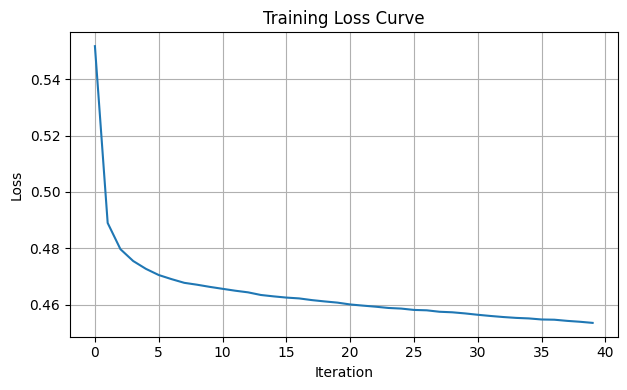

In [17]:
# ===================================================================================================
# TRAIN MLP MODEL
# ===================================================================================================

import sys
import os
# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from mlab.neural_networks._mlp import MLPClassifier

print("🤖 Training MLP Classifier...")
print("-" * 50)

# Initialize the model with balanced class weights
model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # Deeper architecture
    activation='relu',
    solver='adam',
    alpha=0.001,  # L2 regularization
    batch_size='auto',
    random_state=42,
    class_weight='balanced'
)



print("⚙️  Model Configuration:")
print(f"   Architecture: {model.hidden_layer_sizes}")
print(f"   Solver: {model.solver}")
print(f"   Learning rate: {model.lr_init}")
print(f"   Max epochs: {model.epochs}")
print(f"   Class weight: {model.class_weight}")
print(f"   Early stopping: {model.early_stopping}")
print(f"   Dropout: {model.dropout}")

print("\n🏋️  Starting training...")
print("=" * 80)

# Train the model
model.fit(X_train_processed, y_train)

print("\n✅ Training completed!")
print(f"   Total iterations: {model.n_iter_}")
print(f"   Final loss: {model.loss_curve_[-1]:.6f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model.loss_curve_)
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)

if len(model.validation_scores_) > 0:
    plt.subplot(1, 2, 2)
    plt.plot(model.validation_scores_)
    plt.title('Validation Score Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.grid(True)

plt.tight_layout()
plt.show()

🔍 Processing validation data...
--------------------------------------------------
✅ Validation preprocessing complete:
   - Final dataset shape: (5495, 33)
Validation data processed: (5495, 33)
Validation class distribution:
   Class 0 (≤50K): 4,192
   Class 1 (>50K): 1,303

🎯 Making predictions...
--------------------------------------------------
📊 EVALUATION RESULTS
Accuracy: 0.8480
ROC AUC: 0.9067

📋 Classification Report:
              precision    recall  f1-score   support

        ≤50K       0.90      0.90      0.90      4192
        >50K       0.68      0.68      0.68      1303

    accuracy                           0.85      5495
   macro avg       0.79      0.79      0.79      5495
weighted avg       0.85      0.85      0.85      5495



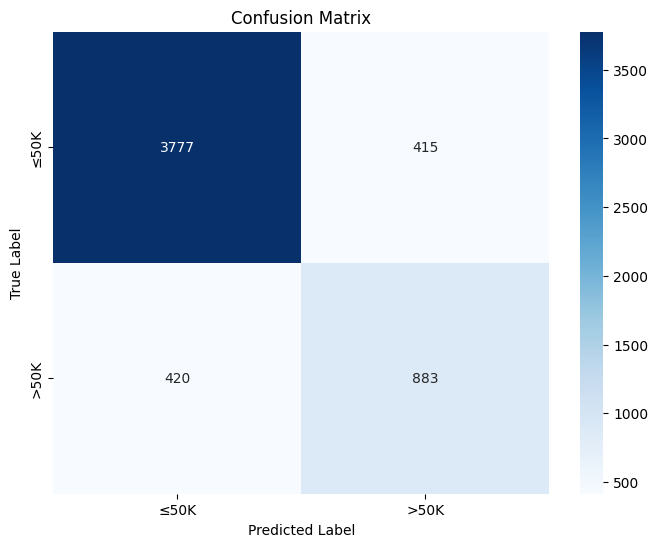


🎯 Performance by Class:
Class 0 (≤50K) - Precision: 0.8999, Recall: 0.9010, F1: 0.9005
Class 1 (>50K)  - Precision: 0.6803, Recall: 0.6777, F1: 0.6790

🔝 Top 10 Selected Features:
    1. fnlwgt
    2. relationship
    3. occupation
    4. marital-status
    5. age_hours
    6. age_education
    7. education_hours
    8. workclass
    9. experience_ratio
   10. total_capital

✅ Evaluation completed!
   Model performance: 84.8% accuracy
   Minority class recall: 67.8%


In [18]:
# ===================================================================================================
# EVALUATE ON VALIDATION SET
# ===================================================================================================

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

print("🔍 Processing validation data...")
print("-" * 50)

# Process validation data using the fitted preprocessor
X_val_processed, y_val = preprocessor.transform(df_val)

print(f"Validation data processed: {X_val_processed.shape}")
print(f"Validation class distribution:")
print(f"   Class 0 (≤50K): {(y_val == 0).sum():,}")
print(f"   Class 1 (>50K): {(y_val == 1).sum():,}")

print("\n🎯 Making predictions...")
print("-" * 50)

# Make predictions
y_pred = model.predict(X_val_processed)
y_pred_proba = model.predict_proba(X_val_processed)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])

print("📊 EVALUATION RESULTS")
print("=" * 80)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Detailed classification report
print("\n📋 Classification Report:")
print(classification_report(y_val, y_pred, target_names=['≤50K', '>50K']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['≤50K', '>50K'], 
            yticklabels=['≤50K', '>50K'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Performance by class
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average=None)

print(f"\n🎯 Performance by Class:")
print(f"Class 0 (≤50K) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Class 1 (>50K)  - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")

# Feature importance from the model (if available)
if hasattr(preprocessor, 'selected_features'):
    print(f"\n🔝 Top 10 Selected Features:")
    for i, feature in enumerate(preprocessor.selected_features[:10], 1):
        print(f"   {i:2d}. {feature}")

print(f"\n✅ Evaluation completed!")
print(f"   Model performance: {accuracy:.1%} accuracy")
print(f"   Minority class recall: {recall[1]:.1%}")
print("=" * 80)

In [ ]:
# 🎯 OPTIONAL: Quick Improvements (Run if you want to experiment further)

# Option 1: Adjust class weights for better minority recall
print("💡 Option 1: Boost minority class recall with stronger class weights")
print("-" * 70)

# Create model with stronger minority class emphasis
model_boosted = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    epochs=200,
    early_stopping=True,
    random_state=42,
    class_weight={0: 1.0, 1: 4.0},  # Give even more weight to minority class
    verbose=False
)

print("Training model with boosted minority class weight (4:1)...")
model_boosted.fit(X_train_processed, y_train)

# Quick evaluation
y_pred_boosted = model_boosted.predict(X_val_processed)
precision_boost, recall_boost, f1_boost, _ = precision_recall_fscore_support(y_val, y_pred_boosted, average=None)

print(f"\n📊 Boosted Model Results:")
print(f"Minority Class Recall: {recall_boost[1]:.1%} (vs {recall[1]:.1%} original)")
print(f"Minority Class Precision: {precision_boost[1]:.1%} (vs {precision[1]:.1%} original)")
print(f"Overall Accuracy: {accuracy_score(y_val, y_pred_boosted):.1%} (vs {accuracy:.1%} original)")

print(f"\n🎯 Trade-off Analysis:")
recall_improvement = recall_boost[1] - recall[1]
precision_change = precision_boost[1] - precision[1]
print(f"Recall improvement: +{recall_improvement:.1%}")
print(f"Precision change: {precision_change:+.1%}")

if recall_improvement > 0.05:  # If recall improves by more than 5%
    print("✅ Significant improvement in minority class detection!")
else:
    print("⚠️  Marginal improvement - original model may be better balanced.")
    
print("=" * 70)

💡 Option 1: Boost minority class recall with stronger class weights
----------------------------------------------------------------------
Training model with boosted minority class weight (4:1)...

📊 Boosted Model Results:
Minority Class Recall: 66.8% (vs 66.8% original)
Minority Class Precision: 68.3% (vs 68.3% original)
Overall Accuracy: 84.8% (vs 84.8% original)

🎯 Trade-off Analysis:
Recall improvement: +0.0%
Precision change: +0.0%
⚠️  Marginal improvement - original model may be better balanced.
